In [1]:
# Run this cell only once (first time) to install missing libraries
!pip install shap lime scikit-learn matplotlib seaborn plotly


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("heart.csv")   # already in your folder
print("COLUMNS:", df.columns.tolist())
print("\nSHAPE:", df.shape)
print("\nUNIQUE VALUES (sample):")
for c in df.columns:
    print(c, "->", df[c].nunique(), "unique, examples:", sorted(df[c].dropna().unique())[:6])
    
df.head()


COLUMNS: ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']

SHAPE: (303, 14)

UNIQUE VALUES (sample):
age -> 41 unique, examples: [np.int64(29), np.int64(34), np.int64(35), np.int64(37), np.int64(38), np.int64(39)]
sex -> 2 unique, examples: [np.int64(0), np.int64(1)]
cp -> 4 unique, examples: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
trtbps -> 49 unique, examples: [np.int64(94), np.int64(100), np.int64(101), np.int64(102), np.int64(104), np.int64(105)]
chol -> 152 unique, examples: [np.int64(126), np.int64(131), np.int64(141), np.int64(149), np.int64(157), np.int64(160)]
fbs -> 2 unique, examples: [np.int64(0), np.int64(1)]
restecg -> 3 unique, examples: [np.int64(0), np.int64(1), np.int64(2)]
thalachh -> 91 unique, examples: [np.int64(71), np.int64(88), np.int64(90), np.int64(95), np.int64(96), np.int64(97)]
exng -> 2 unique, examples: [np.int64(0), np.int64(1)]
oldpeak -> 40 unique, examples: [np.float

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
TARGET_COL = 'output'   # your dataset's label column

print("Target column:", TARGET_COL)
print("Value counts:\n", df[TARGET_COL].value_counts())
print("\nUnique values:", df[TARGET_COL].unique())


Target column: output
Value counts:
 output
1    165
0    138
Name: count, dtype: int64

Unique values: [1 0]


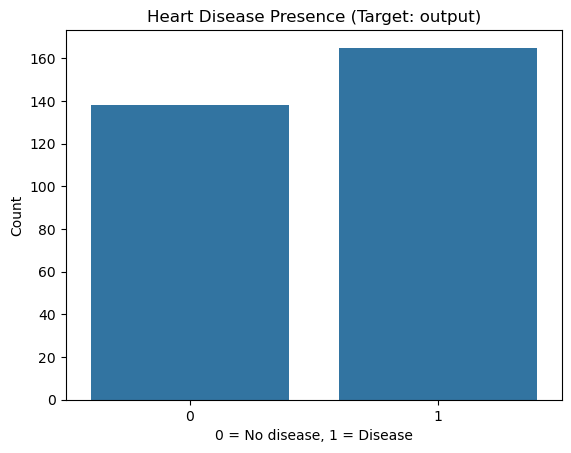

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.countplot(x=TARGET_COL, data=df)
plt.title(f"Heart Disease Presence (Target: {TARGET_COL})")
plt.xlabel("0 = No disease, 1 = Disease")
plt.ylabel("Count")
plt.show()


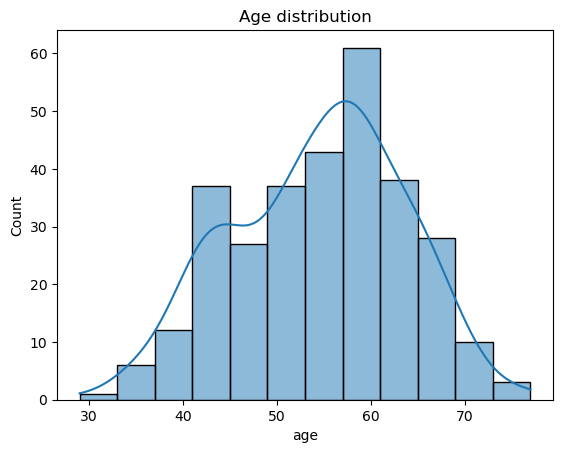

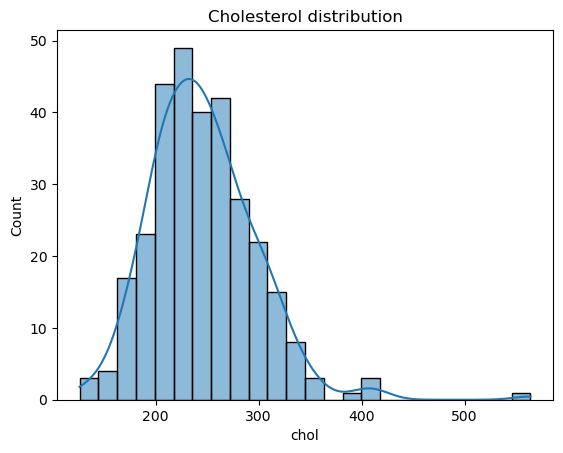

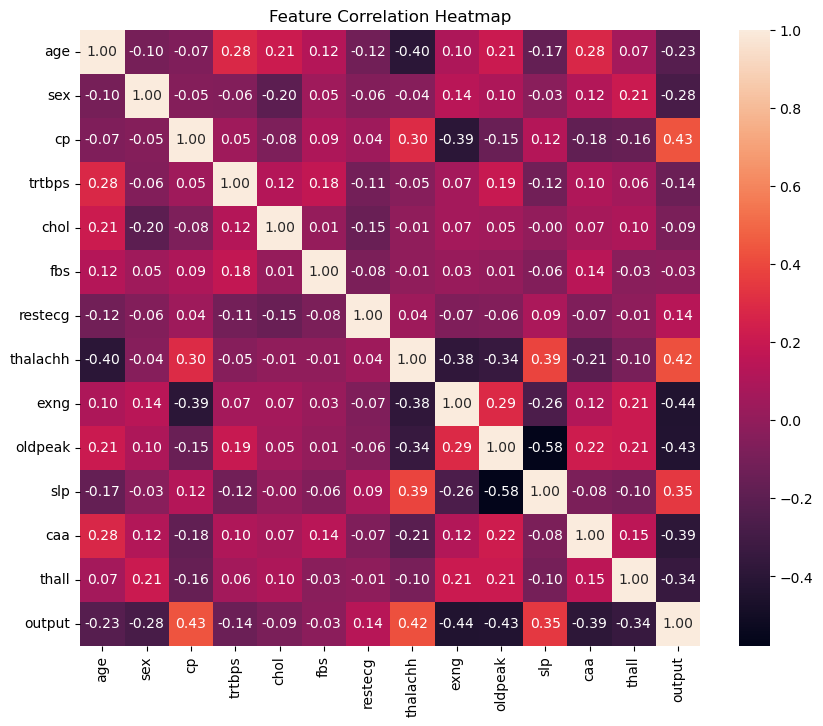

In [5]:
# Age distribution
plt.figure()
sns.histplot(df['age'], kde=True)
plt.title("Age distribution")
plt.show()

# Cholesterol distribution
plt.figure()
sns.histplot(df['chol'], kde=True)
plt.title("Cholesterol distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and label
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

# If y is not numeric (unlikely), try to convert automatically:
if y.dtype == object:
    print("Converting target to numeric...")
    y = pd.to_numeric(y, errors='coerce')
    print("After conversion:", y.unique())

# Train-test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


X_train shape: (242, 13) X_test shape: (61, 13)


Logistic Regression Accuracy: 0.8032786885245902
ROC-AUC: 0.8690476190476191

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61



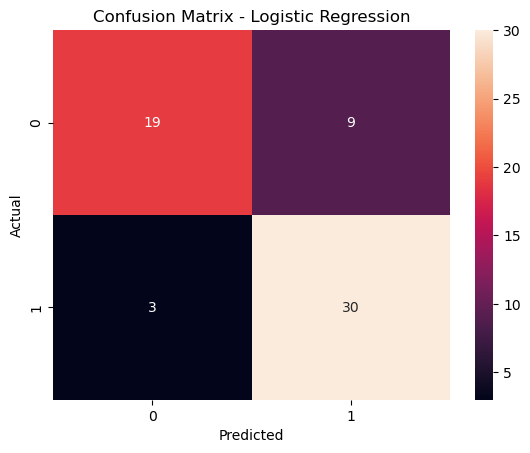

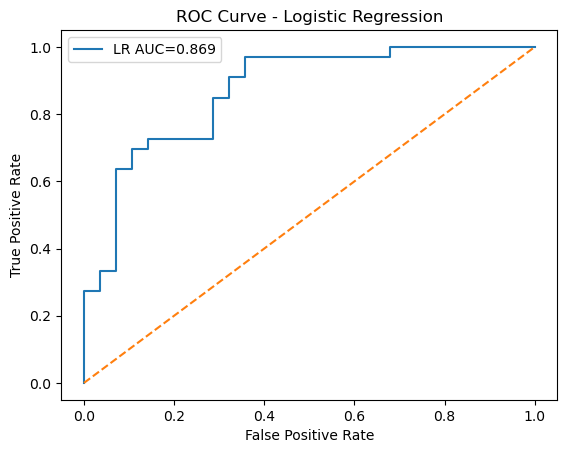

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure()
plt.plot(fpr, tpr, label=f"LR AUC={roc_auc_score(y_test, y_prob_lr):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


Random Forest Accuracy: 0.819672131147541
Random Forest ROC-AUC: 0.9080086580086579


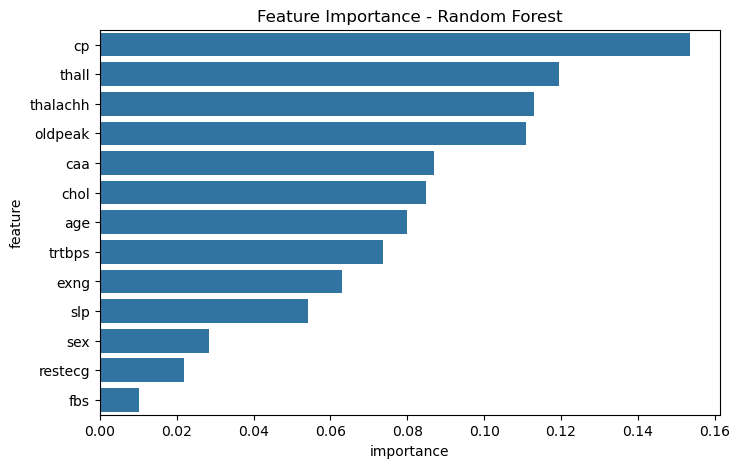

,feature,importance
2,cp,0.153619
12,thall,0.119375
7,thalachh,0.113028
9,oldpeak,0.110831
11,caa,0.086868
4,chol,0.084881
0,age,0.080043
3,trtbps,0.073645
8,exng,0.062993
10,slp,0.054143


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# Feature importance
feat_imp = pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Feature Importance - Random Forest")
plt.show()
feat_imp


In [14]:
# Run this and copy the printed lines back here
print("hasattr(shap_vals,'values'):", hasattr(shap_vals, "values"))
if hasattr(shap_vals, "values") and shap_vals.values is not None:
    print("shap_vals.values.shape:", shap_vals.values.shape)
else:
    try:
        print("shap_vals.shape:", shap_vals.shape)
    except Exception as e:
        print("Could not read .shape property:", e)


hasattr(shap_vals,'values'): True
shap_vals.values.shape: (61, 13, 2)


Original shap_vals.values.shape: (61, 13, 2)
Has data?: True
Feature names available?: True
Selected class index: 1 -> shap_pos.shape: (61, 13)
Original base_values shape: (61, 2)
base_for_pos shape/value: (61,)
Created new Explanation: <class 'shap._explanation.Explanation'> values.shape: (61, 13)


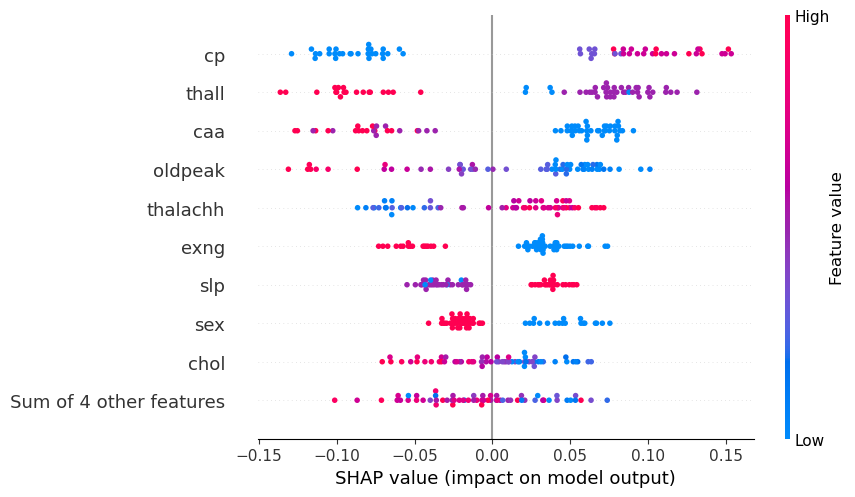

In [20]:
import shap
import numpy as np

# Inspect current object a bit
print("Original shap_vals.values.shape:", shap_vals.values.shape)
print("Has data?:", hasattr(shap_vals, "data"))
print("Feature names available?:", hasattr(shap_vals, "feature_names") and shap_vals.feature_names is not None)

# Extract positive-class (index 1) explanations
vals = shap_vals.values  # shape (n_samples, n_features, n_classes) in your case
if vals.ndim == 3:
    # pick index 1 (positive class). If you want the other class, use index 0.
    class_index = 1
    shap_pos = vals[:, :, class_index]   # now shape (n_samples, n_features)
    print("Selected class index:", class_index, "-> shap_pos.shape:", shap_pos.shape)
else:
    shap_pos = vals
    print("No class axis detected, using shap_vals.values directly:", shap_pos.shape)

# Handle base_values (offsets)
base = getattr(shap_vals, "base_values", None)
base_for_pos = None
if base is not None:
    base_arr = np.array(base)
    print("Original base_values shape:", base_arr.shape)
    # base could be (n_samples, n_classes) or (n_classes,) or (n_samples,)
    if base_arr.ndim == 2 and base_arr.shape[1] > 1:
        base_for_pos = base_arr[:, class_index]        # per-sample base for class
    elif base_arr.ndim == 1 and base_arr.size > 1:
        # a vector of class-level base values
        base_for_pos = base_arr[class_index]
    else:
        # single value or already matched
        base_for_pos = base_arr

print("base_for_pos shape/value:", None if base_for_pos is None else np.shape(base_for_pos))

# Data and feature names
data = getattr(shap_vals, "data", None)
feature_names = getattr(shap_vals, "feature_names", None)

# Create a new Explanation object for the chosen class
try:
    new_exp = shap.Explanation(
        values=shap_pos,
        base_values=base_for_pos,
        data=data,
        feature_names=feature_names
    )
    print("Created new Explanation:", type(new_exp), "values.shape:", new_exp.values.shape)
except Exception as e:
    print("Could not create shap.Explanation object; will proceed to attempt plotting raw arrays. Error:", e)
    new_exp = None

# Try beeswarm (preferred) then fallback to bar
try:
    if new_exp is not None:
        shap.plots.beeswarm(new_exp)
    else:
        # fallback: pass numpy array and feature names if available
        shap.plots.beeswarm(shap_pos, feature_names=feature_names)
except Exception as e:
    print("Beeswarm failed, trying a bar plot as fallback. Error was:", e)
    try:
        if new_exp is not None:
            shap.plots.bar(new_exp)
        else:
            shap.plots.bar(shap_pos, feature_names=feature_names)
    except Exception as e2:
        print("Bar plot also failed. Final error:", e2)
        # print some debug info
        print("DEBUG: shap_pos.shape:", np.shape(shap_pos))
        if base_for_pos is not None:
            print("DEBUG: base_for_pos.shape:", np.shape(base_for_pos))
        if feature_names is not None:
            print("DEBUG: len(feature_names):", len(feature_names))


In [17]:
import numpy as np
import pandas as pd
from lime import lime_tabular

# 1) Ensure training data passed to LIME is a numpy array
train_array = np.array(X_train)           # X_train is a DataFrame
feature_names = X.columns.tolist()        # explicit feature names

# 2) Create a predict function that accepts numpy arrays and calls the classifier with a DataFrame
def predict_proba_for_lime(x_numpy):
    # x_numpy: 2D numpy array from LIME
    # convert back to DataFrame so sklearn model sees column names (avoids sklearn warning)
    df = pd.DataFrame(x_numpy, columns=feature_names)
    return rf.predict_proba(df)   # rf is your trained RandomForestClassifier

# 3) Create the Lime explainer with numpy training data and explicit feature names
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data = train_array,
    feature_names = feature_names,
    class_names = ["No Heart Disease", "Heart Disease"],
    mode = "classification",
    random_state = 42
)

# 4) Choose a sample and explain (pass numpy row to explain_instance)
i = 0
sample = X_test.iloc[i]               # pandas Series for display
sample_array = sample.values          # 1D numpy array for explain_instance

# 5) Generate explanation
lime_exp = lime_explainer.explain_instance(
    data_row = sample_array,
    predict_fn = predict_proba_for_lime,
    num_features = 8
)

# 6) Show results in notebook (table + chart)
print("Explaining test sample index:", i)
display(sample.to_frame().T)   # show original feature values as a single-row table
lime_exp.show_in_notebook(show_table=True)


Explaining test sample index: 0


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
179,57.0,1.0,0.0,150.0,276.0,0.0,0.0,112.0,1.0,0.6,1.0,1.0,1.0


In [18]:
# Predict heart attack risk for a sample patient
i = 0
sample = X_test.iloc[i:i+1]
risk_score = rf.predict_proba(sample)[0][1] * 100

print(f"Predicted Heart Attack Risk for sample {i}: {risk_score:.2f}%")


Predicted Heart Attack Risk for sample 0: 17.50%
